In [1]:
from fastai.vision.all import *

# LSH

LSH is an algorithm for clustering of high dimensionnal data. There are several ways of implementing the algorithm. We'll look at random projections and random rotations.

## Random projections

[Yannick](https://www.youtube.com/watch?v=i4H0kjxrias&t=1s) explains LSH with random projections, and the same with this [blog post](https://www.pragmatic.ml/reformer-deep-dive/). That means that in a 2D case we can envision lines drawn at random, and points grouped depending on if they point in a similar direction or not. This method is probabilistic as points that are close can end up in different buckets by chance, but they will have a high probability of beeing grouped to gether. Illustration from the blog:
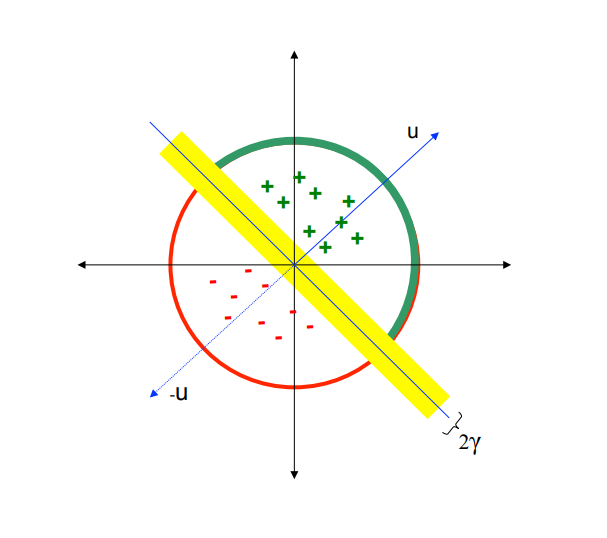

We'll demonstrate random projections for the 2 dimensional case. First we fix some points in the 2d plane. We'll do everything deterministically to begin with:

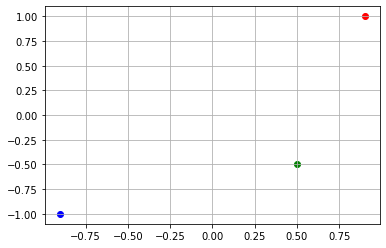

In [2]:
points = np.array([[0.9, 1],
                   [-0.9, -1],
                   [0.5, -.5]])
fig ,ax = plt.subplots()
for (x, y),c in zip(points, ['r', 'b', 'g']):
        ax.scatter(x, y, c=c)
ax.grid();

Next we make a vector assumed to pass thru the origin. We'll make it a positive unit vector so we can think of it pointing up and to the right. We can manually project this vector from say x = [-1, 1] and display it as a line:

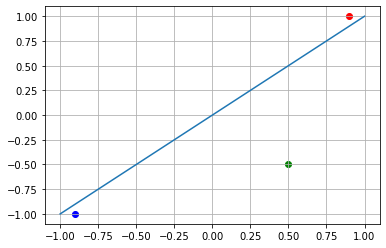

In [3]:
u = np.array([1, 1])
ax.plot([-1, 1], [-1, 1])
fig

The dot product between vectors a and b is the lenght of a projected onto b multiplied with the length of b. So if two vectors point in the same direction their dot product is positive and vice versa. If vectors are perpendicular the dot product is 0. The doproduct is defined by summing up the pairwise products of two vectors. Note that we can think of our points as vectors from the origin. Taking the dot product of the red point and u, we get as expected a postivite dotproduct:

In [4]:
(points[0]*u).sum()

1.9

We can calculate the dotproduct for all our points by matrix multiplication. The red vector points along u, the blue opposite, and the green on is perpendicular:

In [5]:
points@u.T

array([ 1.9, -1.9,  0. ])

We can generalize this in a function by adding randomness, and only keeping the sign of the dotproduct.

In [6]:
def rand_proj(points):
    u = np.random.randn(1,2) # 1 projection in 2-dim
    dots = points@u.T
    return np.sign(dots)

rand_proj(points)

array([[ 1.],
       [-1.],
       [ 1.]])

> **In this case we have two buckets, -1 and 1**

We can also repeat the bucketing process n times to get a more stable estimate. Each run will produce a different results. Eg. the first column below represents a new hash bucket for the red point.

In [7]:
[rand_proj(points).squeeze() for _ in range(5)]

[array([-1.,  1., -1.]),
 array([ 1., -1., -1.]),
 array([ 1., -1.,  1.]),
 array([ 1., -1., -1.]),
 array([ 1., -1., -1.])]

We can also generalize this to produce more than two buckets. The number of buckets is 2x the number of random projections:

In [8]:
def rand_proj(points, n_projections=2, n_dim=2):
    u = np.random.randn(n_projections, n_dim)
    dots = points@u.T
    return np.sign(dots)

rand_proj(points, n_projections=2)

array([[ 1., -1.],
       [-1.,  1.],
       [-1.,  1.]])

In this case we have 4 buckets: [-1,-1], [-1,1], [1,-1], [1,1]. Which could be further combined into a single id [0,1,2,3]

In [9]:
def rand_proj(points, n_projections=2, n_dim=2):
    u = np.random.randn(n_projections, n_dim)
    dots = points@u.T
    return np.sign(dots)

rand_proj(points, n_projections=2)

array([[-1.,  1.],
       [ 1., -1.],
       [ 1., -1.]])

## random rotations

The paper instead opts for an angular interpretation of LSH:
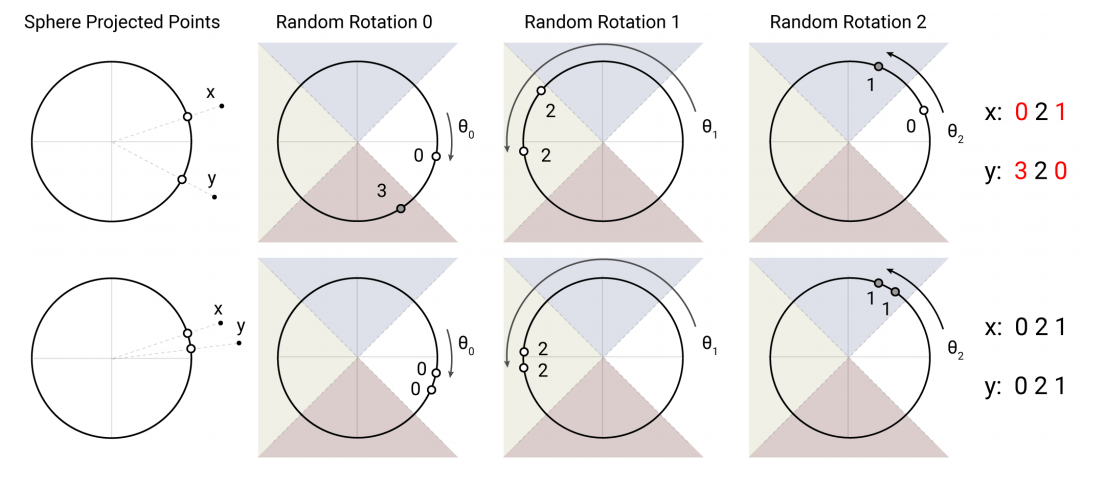

In the 2d case each point is projected onto a unit sphere, and then rotated randomly. Bucketing will depend on which of the sectors it ends up in. The algorithm is decribed as:  

*To get b hashes, we first fix a random matrix R of size [dk, b/2]. We then define h(x) = arg max([xR; −xR]) where [u; v] denotes the concatenation of two vectors. This method is a known LSH scheme (Andoni et al., 2015) and is easy to implement and apply to batches of vectors.*

The blog has an implementation to compute a single hash wich follows these steps.

In [10]:
def rand_rotations(x, hidden_dim, n_buckets):
    random_rotations = np.random.randn(hidden_dim, n_buckets // 2)
    rotated_vectors = np.dot(x, random_rotations)
    rotated_vectors = np.hstack([rotated_vectors, -rotated_vectors])
    return np.argmax(rotated_vectors, axis=-1)

In [11]:
rand_rotations(points, hidden_dim=2, n_buckets=4)

array([1, 3, 1])

This has the nice property of directly giving us the hash-bucket id instead of our list above. The next step will be to scale the algorithm to do several rounds. One could simply loop it, but it will be more effectient to add an extra dimension to our matrices. We will also need to take care of batch and attention head dimensions.

## Incorporation of batches and multiple hashing rounds

In [12]:
from einops import rearrange, repeat, reduce

The code for the LSH algorithm used for the paper can be found in the [trax library](https://github.com/google/trax/blob/6b4ee9f7473934d15f7b872000be43b1a984bd81/trax/layers/research/efficient_attention.py#L56). Lucidrains also has a stripped down [version](https://github.com/lucidrains/reformer-pytorch/blob/5eb10786dee3fcdb0092a3d8cc415665f0bbdb14/reformer_pytorch/reformer_pytorch.py#L207). We'll base our algorithm on lucidrains, but simplify even further to make the algorithm as clear as possible:
* we'll assume rehashing each round as in trax library
* no dropout on the vectors to be hashed.
* won't pay attention to device at the moment
* assume correct dytpes passed in
* similar number of rotations per head

That means we have to:
1. Keep track of the various dimension
2. perform the random_rotations part of the algorithm (as above)
3. Structure the output depending on number of rounds and buckets

In [13]:
# From https://github.com/lucidrains/reformer-pytorch/blob/master/reformer_pytorch/reformer_pytorch.py

def hash_vectors(vecs, n_buckets=2, n_rounds=1):

    # 1. account for the input shapes. vecs = [bs, sl, hidden_dim]
    assert n_buckets % 2 == 0
    batch_size, _, hidden_dim = vecs.shape
    rotations_shape = (hidden_dim, n_rounds, n_buckets // 2) 

    # 2. get the dotproduct, cat and argmax like in the section above

    random_rotations = repeat(torch.randn(rotations_shape),  #repeat rotations accross the batch dimension
                              'h nr nb -> bs h nr nb', bs=batch_size)                               
    
    rotated_vecs = torch.einsum('bsh,bhrn->brsn', 
                                vecs,               # [bs, sl, hidden_dim]
                                random_rotations)   # [bs, hidden_dim, n_rounds, n_buckets//2]
                                                    # rotated vecs: [bs, n_rounds, sl, n_buckets//2]
        
    rotated_vecs = torch.cat([rotated_vecs, -rotated_vecs], dim=-1) # [bs, n_rounds, sl, n_buckets]
    buckets = torch.argmax(rotated_vecs, dim=-1)                    # [bs, n_rounds, sl] 

    # 3. Next we add offsets so that bucket numbers from different hashing rounds don't overlap.

    offsets = torch.arange(n_rounds)                               # list of [0,1,2,..n_rounds-1]
    offsets = rearrange(offsets * n_buckets, '(r)-> (1)(r)(1)')    # [1, n_rounds, 1]
    buckets = rearrange(buckets+offsets, 'bs r sl -> bs (r sl)')   # [bs, (n_rounds*sl)]
    return buckets

Let's pass our trusty old points in, but first convert to tensors, and create a batch dimension first.

In [14]:
t = torch.tensor(points, dtype=torch.float32)
t = rearrange(t, 'b d -> b () d')
hash_vectors(t, n_buckets=2), hash_vectors(t, n_buckets=2, n_rounds=5)

(tensor([[0],
         [1],
         [0]]),
 tensor([[1, 2, 5, 6, 8],
         [0, 3, 4, 7, 9],
         [1, 2, 5, 7, 8]]))

In the multiround case, the result from each hashing round is stacked along the 1 dimension, and an offset is added so each one has a unique index, from [0 to n_rounds * n_hases -1], [0-9] in this case.

In the transformer setting the q and k matrix shapes will be: [bs, sl, hidden_dim]

In [15]:
t = torch.randn(64, 512, 128)
out = hash_vectors(t, n_buckets=4, n_rounds=1)
out.shape, out.min(), out.max()

(torch.Size([64, 512]), tensor(0), tensor(3))

In [16]:
out = hash_vectors(t, n_buckets=4, n_rounds=3)
out.shape, out.min(), out.max()

(torch.Size([64, 1536]), tensor(0), tensor(11))

# LSH applied to attention

To be continued...